In [1]:
#import library which are required
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import io
from sklearn import preprocessing
from functools import reduce


%reload_ext google.colab.data_table

In [2]:
#Reading the csv file to get the confirmed cases
confirmed_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

#Reading the csv file to get the total deaths
deaths_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

#Storing the Data into dataframe for confirmed cases and dealth cases
confirmed_cases_df = pd.read_csv(confirmed_cases_url)
deaths_df = pd.read_csv(deaths_url)

#sum of confirm cases for all countries based on date
confirmed_cases_global = pd.DataFrame(confirmed_cases_df.iloc[:,4:].sum()).reset_index()
#defined dataframe columns
confirmed_cases_global.columns = ['Date', "ConfirmCases"]

#sum of dealth cases for all countries based on date
deaths_global = pd.DataFrame(deaths_df.iloc[:,4:].sum()).reset_index()
#defined dataframe columns for Dealth cases
deaths_global.columns = ['Date', "Deaths"]

#combined confirmed and death cases for common column date
global_data = pd.merge(confirmed_cases_global, deaths_global, on='Date')
#convert date value into datetime datatype
global_data['Date']= pd.to_datetime(global_data['Date'])
global_data

,Date,ConfirmCases,Deaths
0,2020-01-22,557,17
1,2020-01-23,657,18
2,2020-01-24,944,26
3,2020-01-25,1437,42
4,2020-01-26,2120,56
...,...,...,...
1138,2023-03-05,676024901,6877749
1139,2023-03-06,676082941,6878115
1140,2023-03-07,676213378,6879038
1141,2023-03-08,676392824,6880483


In [3]:
#research stock for industries (Overall American, overall Candian, Travel, Real Estate, Precious metals (Gold, Silver, Platinum and so on)) from AlphaVantage API
overall_us_stock = 'SPY' # Overall American Market
overall_ca_stock = 'XIU.TO' # Overall Canadian Market
travel_stock = 'EXPE' # Travel sector (Expedia)
real_estate_stock = 'VNQ' # The Real Estate sector (Vanguard Real Estate ETF)
precious_metals_stock = 'GLD' # Precious metals (Gold ETF)
api_key = 'QJCYHOCEUMEEI17F'
base_url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED'
interval = 'daily'
outputsize = 'compact'
#create URL to get data as mentioned from alphavantage api 
overall_us_stock_url = f"{base_url}&symbol={overall_us_stock}&apikey={api_key}&interval={interval}&outputsize={outputsize}"
overall_ca_stock_url = f"{base_url}&symbol={overall_ca_stock}&apikey={api_key}&interval={interval}&outputsize={outputsize}"
travel_stock_url = f"{base_url}&symbol={travel_stock}&apikey={api_key}&interval={interval}&outputsize={outputsize}"
real_estate_stock_url = f"{base_url}&symbol={real_estate_stock}&apikey={api_key}&interval={interval}&outputsize={outputsize}"
precious_metals_stock_url = f"{base_url}&symbol={precious_metals_stock}&apikey={api_key}&interval={interval}&outputsize={outputsize}"

In [4]:
# get response for Overall American Market stock from API
overall_us_response = requests.get(overall_us_stock_url)
SPY_data = pd.DataFrame.from_dict(overall_us_response.json()['Time Series (Daily)'], orient='index')
# create dataframe with required data
SPY_data['Date'] = pd.to_datetime(SPY_data.index)
SPY_data = SPY_data[['Date', '2. high', '3. low']]
SPY_data.columns = ['Date', 'SPY_High', 'SPY_Low']

In [5]:
# get response for Overall Canadian Market stock from API
overall_ca_response = requests.get(overall_ca_stock_url)
XIU_data = pd.DataFrame.from_dict(overall_ca_response.json()['Time Series (Daily)'], orient='index')
# create dataframe with required data
XIU_data['Date'] = pd.to_datetime(XIU_data.index)
XIU_data = XIU_data[['Date', '2. high', '3. low']]
XIU_data.columns = ['Date', 'XIU_High', 'XIU_Low']

In [6]:
# get response for travel stock for Expedia from API
travel_response = requests.get(travel_stock_url)
EXPE_data = pd.DataFrame.from_dict(travel_response.json()['Time Series (Daily)'], orient='index')
# create dataframe with required data
EXPE_data['Date'] = pd.to_datetime(EXPE_data.index)
EXPE_data = EXPE_data[['Date', '2. high', '3. low']]
EXPE_data.columns = ['Date', 'EXPE_High', 'EXPE_Low']

In [7]:
# get response for Vanguard Real Estate stock  from API
real_estate_response = requests.get(real_estate_stock_url)
VNQ_data = pd.DataFrame.from_dict(real_estate_response.json()['Time Series (Daily)'], orient='index')
# create dataframe with required data
VNQ_data['Date'] = pd.to_datetime(VNQ_data.index)
VNQ_data = VNQ_data[['Date', '2. high', '3. low']]
VNQ_data.columns = ['Date', 'VNQ_High', 'VNQ_Low']

In [8]:
# get response for precious metal such as gold stock  from API
precious_metals_response = requests.get(precious_metals_stock_url)
GOLD_data = pd.DataFrame.from_dict(precious_metals_response.json()['Time Series (Daily)'], orient='index')
# create dataframe with required data
GOLD_data['Date'] = pd.to_datetime(GOLD_data.index)
GOLD_data = GOLD_data[['Date', '2. high', '3. low']]
GOLD_data.columns = ['Date', 'GLD_High', 'GLD_Low']

In [9]:
#merge all dataframe created from alphavantage api
stock_api_combined_data = reduce(lambda x,y: pd.merge(x,y, on='Date', how='outer'), [SPY_data, XIU_data, EXPE_data, VNQ_data, GOLD_data])
#merged data frame with API result and confirmed and dealth cases of covid based on Data and fill null values with 0
merged_dataFrame = pd.merge(global_data,stock_api_combined_data, on='Date',how = 'outer').fillna(0)
display(merged_dataFrame)
s = merged_dataFrame.select_dtypes(include='object').columns
merged_dataFrame[s] = merged_dataFrame[s].astype("float")
merged_dataFrame["ConfirmCases"] = merged_dataFrame["ConfirmCases"].astype("int")
merged_dataFrame["Deaths"] = merged_dataFrame["Deaths"].astype("int")
#create excel file from combined data frame
merged_dataFrame.to_excel("output.xlsx",sheet_name='Sheet_name_1')
merged_dataFrame.dtypes

,Date,ConfirmCases,Deaths,SPY_High,SPY_Low,XIU_High,XIU_Low,EXPE_High,EXPE_Low,VNQ_High,VNQ_Low,GLD_High,GLD_Low
0,2020-01-22,557.0,17.0,0,0,0,0,0,0,0,0,0,0
1,2020-01-23,657.0,18.0,0,0,0,0,0,0,0,0,0,0
2,2020-01-24,944.0,26.0,0,0,0,0,0,0,0,0,0,0
3,2020-01-25,1437.0,42.0,0,0,0,0,0,0,0,0,0,0
4,2020-01-26,2120.0,56.0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164,2023-03-16,0.0,0.0,396.47,386.29,29.78,29.1,95.82,90.34,82.83,80.95,179.654,177.87
1165,2023-03-15,0.0,0.0,389.49,383.71,29.52,29.14,92.47,90.2475,82.85,81.295,180.13,177.49
1166,2023-03-14,0.0,0.0,393.45,387.05,30.12,29.67,99.18,93.3413,83.62,81.77,177.59,176.21
1167,2023-03-13,0.0,0.0,390.39,380.65,29.93,29.47,96.57,93.86,82.955,80.09,178.02,176.3


Date            datetime64[ns]
ConfirmCases             int64
Deaths                   int64
SPY_High               float64
SPY_Low                float64
XIU_High               float64
XIU_Low                float64
EXPE_High              float64
EXPE_Low               float64
VNQ_High               float64
VNQ_Low                float64
GLD_High               float64
GLD_Low                float64
dtype: object

<Axes: xlabel='Date'>

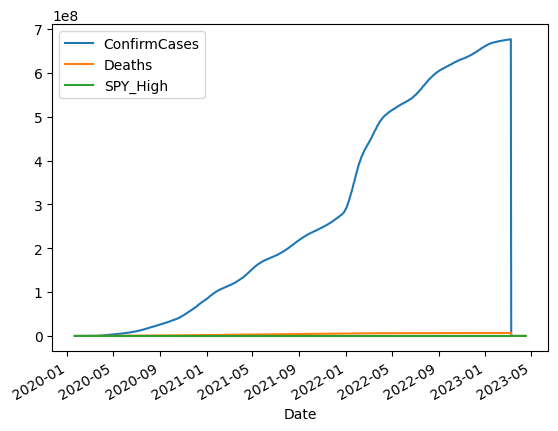

In [10]:
merged_dataFrame.plot(x="Date", y=["ConfirmCases", "Deaths","SPY_High"])

<Axes: xlabel='Date'>

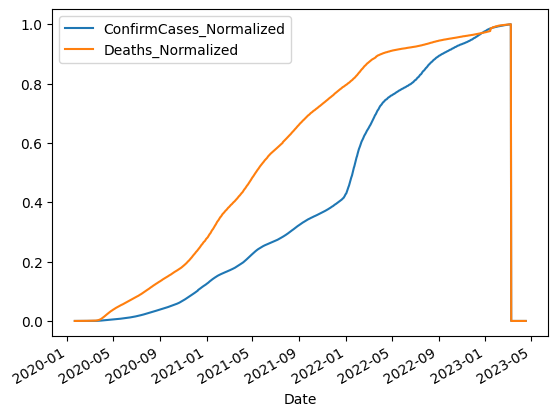

In [11]:
merged_dataFrame["ConfirmCases_Normalized"] = preprocessing.MinMaxScaler().fit_transform(np.array(merged_dataFrame["ConfirmCases"]).reshape(-1,1))
merged_dataFrame["Deaths_Normalized"] = preprocessing.MinMaxScaler().fit_transform(np.array(merged_dataFrame["Deaths"]).reshape(-1,1))
merged_dataFrame.plot(x="Date", y=["ConfirmCases_Normalized", "Deaths_Normalized"])

0        557
1        657
2        944
3       1437
4       2120
        ... 
1164       0
1165       0
1166       0
1167       0
1168       0
Name: ConfirmCases, Length: 1169, dtype: int64

,ConfirmCases,Deaths
0,557,17
1,657,18
2,944,26
3,1437,42
4,2120,56
...,...,...
1164,0,0
1165,0,0
1166,0,0
1167,0,0


KeyError: ignored

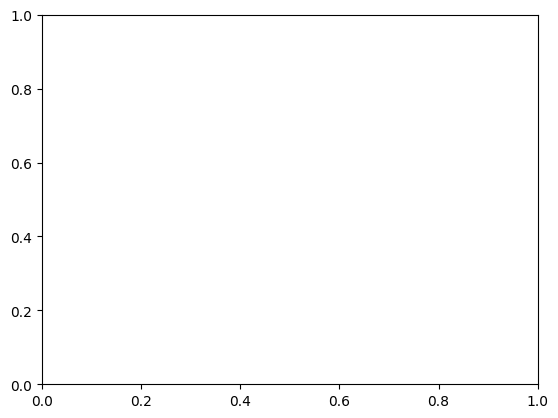

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
display(merged_dataFrame['ConfirmCases'])
# Defining the stock data
stock_data = pd.DataFrame({'Confirmed Cases': merged_dataFrame['ConfirmCases'],
                           'Death Cases': merged_dataFrame['Deaths']},
                          index=merged_dataFrame['Date'])

df2 = merged_dataFrame.filter(['ConfirmCases','Deaths'], axis=1)
display(df2)
#display(stock_data)
# Ploting the data using the line graph
fig, ax = plt.subplots()
ax.plot(stock_data.index, stock_data['High'], label='High Price')
ax.plot(stock_data.index, stock_data['Low'], label='Low Price')
ax.legend()
plt.show()


#lines = merged_dataFrame.plot.line()